In [1]:
%load_ext autoreload
%autoreload 2

from resource import *

%matplotlib inline
plt.style.use('dark_background')

1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log (как вариант - использовать np.clip или np.where).

In [2]:
X = np.array([[1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж репетитора
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],  # средняя стоимость занятия
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype=np.float64).T  # квалификация репетитора

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=np.float64)  # поступил или нет ученик на специальность Математика

In [3]:
def calc_logloss(y, y_pred):
    y_pred_clipped = np.where(y_pred == 0, 1e-15, np.where(y_pred == 1, 1 - 1e-15, y_pred))
    # y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # err = np.mean(-y * np.log(y_pred + 1e-15) - (1.0 - y) * np.log(1.0 - y_pred + 1e-15))
    err = np.mean(-y * np.log(y_pred_clipped) - (1.0 - y) * np.log(1.0 - y_pred_clipped))
    return err

In [4]:
# Пример применения
y_true = 0
y_pred = 1
calc_logloss(y_true, y_pred)

34.53957599234088

2. На данных из урока изучите влияние гиперпараметров на ошибку алгоритма. Подберите аргументы функции eval_LR_model для логистической регрессии таким образом, чтобы log loss не превышал значение 0.3 (0.1). Как изменились веса?

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Масштабируем колонку со стоимостью занятия

In [6]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[:, 1] = scaler.fit_transform(X_scaled[:, 1])
X_scaled[:, 1]

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

In [7]:
def calc_gradient(samples, targets, yhat):
    return 2 * (yhat - targets) @ samples / samples.shape[0]


def predict(samples, weight):
    return samples @ weight


def update(samples, targets, yhat, weight, alpha):
    return weight - alpha * calc_gradient(samples, targets, yhat)

In [8]:
def eval_lr_model(samples, targets,
                  iterations,
                  alpha=1e-3, min_los=1,
                  print_cost=True, fit_intercept=True):
    np.random.seed(42)

    if fit_intercept:
        samples = np.hstack((np.ones((samples.shape[0], 1)), samples))
    w = np.random.randn(samples.shape[1])

    loss = calc_logloss(targets, sigmoid(np.dot(samples, w)))
    for i in range(1, iterations + 1):
        yhat = sigmoid(predict(samples, w))
        new_weight = update(samples, targets, yhat, w, alpha)
        loss = calc_logloss(targets, sigmoid(np.dot(samples, new_weight)))
        if i < iterations and loss < min_los:
            print(f'Model iterations: {i}, loss: {loss}, weight={w} ...')
            break
        if print_cost == True and i % 100 == 0:
            print(i, w, loss)
        w = new_weight
    return w, loss

In [9]:
eval_lr_model(X_scaled, y, iterations=1000, alpha=1, min_los=0.3, print_cost=True)

100 [-4.93512183 -0.27160891 -0.11835431  6.59492325] 1.23432503325964
Model iterations: 151, loss: 0.29944149711205514, weight=[-7.80817012 -1.5183843  -0.74699779  7.3319981 ] ...


(array([-7.80817012, -1.5183843 , -0.74699779,  7.3319981 ]),
 0.29944149711205514)

In [10]:
eval_lr_model(X_scaled, y, iterations=10000, alpha=1, min_los=0.1, print_cost=True)

100 [-4.93512183 -0.27160891 -0.11835431  6.59492325] 1.23432503325964
200 [-8.18720769 -1.05100497 -1.38340955  8.96806899] 1.3523364339574155
300 [-10.87310042  -1.7398129   -2.19145519   9.25699022] 0.26645782813403157
400 [-12.10337872  -1.77533439  -2.57895763  10.22992917] 0.2510543069728562
500 [-13.22441149  -1.81729246  -2.94121175  11.11077753] 0.2387631620297978
600 [-14.26080562  -1.85894107  -3.27157134  11.92983339] 0.22822782066885033
700 [-15.22830907  -1.89854516  -3.57680676  12.69777238] 0.21899154727697406
800 [-16.13696825  -1.93452009  -3.86096565  13.42258182] 0.2107733406994703
900 [-16.99314126  -1.96451023  -4.12628888  14.11222864] 0.2034391112104028
1000 [-17.80262577  -2.00499038  -4.37290107  14.77419966] 0.197356743469764
1100 [-18.5791518   -2.07127072  -4.60511659  15.40448605] 0.1920682462122951
1200 [-19.32463112  -2.13612009  -4.82710858  16.00939239] 0.1871967995027222
1300 [-20.04144569  -2.19864055  -5.03995461  16.59102326] 0.18269393442296059
14

(array([-43.12422716,  -4.21733156, -11.72274232,  35.19008921]),
 0.09999999367728905)

In [11]:
from matplotlib.colors import ListedColormap


class LogisticRegression(ElasticGradientLinearRegression):
    def __init__(self,
                 threshold: float = 0.7,
                 **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold

    def loss(self):
        eps = 1e-15
        yhat = self.predict()

        l1_term = self.l1_penalty * np.sum(self.weight[1:])
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weight[1:]))

        y_hat_clipped = np.where(yhat == 0, eps, np.where(yhat == 1, 1 - eps, yhat))

        loss = np.mean(-(self.targets * np.log(y_hat_clipped) + (1 - self.targets) * np.log(
            1 - y_hat_clipped))) + l1_term + l2_term
        return loss

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def predict(self):
        return self.sigmoid(self.samples @ self.weight)

    def to_class(self, logit):
        return (logit >= self.threshold) * 1

    def calc_predict(self):
        yhat = self.predict()
        return self.to_class(yhat)

    def classification_report(self):
        tp = tn = fp = fn = 0

        yhat = self.calc_predict()
        total = yhat.size
        n = np.sum(yhat == 0)
        p = np.sum(yhat == 1)
        
        for yhat_i, yi in zip(yhat, self.targets):
            match yi, yhat_i:
                case 1, 1: tp += 1
                case 0, 0: tn += 1
                case 1, 0: fn += 1
                case 0, 1: fp += 1

        print('True Positives:%.4f' % (tp / p), end='\t')
        print('True Negatives:%.4f' % (tn / n))
        print('False Positives:%.4f' % (fp / p), end='\t')
        print('False Negatives:%.4f' % (fn / n))
        print('Accuracy равно:%.4f' % ((tp + tn) / total))
        print('Recall равно:%.4f' % (tp / (tp + fn)), end='\t')
        print('Precision равно:%.4f' % (tp / (tp + fp)))
        print('F-мера равно:%.4f' % (tp / (tp + 0.5 * (fp + fn))))



Cost at iteration 100 is 0.33284466941421276, weight=[-5.52300314 -1.16445871 -0.31450324  5.25517149]
Model alpha: 1.0, diff_mse: 1e-15, iterations: 158, loss: 0.2987970911009851 ...


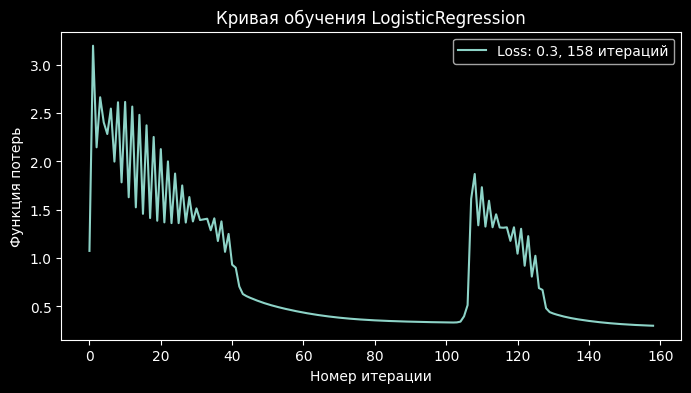

CPU times: total: 422 ms
Wall time: 418 ms


array([-7.97628655, -1.54184807, -0.78420239,  7.48344041])

In [12]:
%%time
log_regressor = LogisticRegression(samples=X_scaled, targets=y,
                                   alpha=1e-00, diff_mse=1e-15, min_los=0.3,
                                   print_cost=True, fit_intercept=True,
                                   l1_penalty=0.00, l2_penalty=0.00)
log_l = log_regressor.fit()
log_w = log_regressor.get_weights()
plot_learning_curves(model=log_regressor)
log_w

Cost at iteration 100 is 0.33284466941421276, weight=[-5.52300314 -1.16445871 -0.31450324  5.25517149]
Cost at iteration 200 is 0.2805029897313212, weight=[-8.78850633 -1.29819912 -1.54886381  7.57300214]
Cost at iteration 300 is 0.27251915509375263, weight=[-10.7686151   -1.38789752  -2.25175673   9.39352708]
Cost at iteration 400 is 0.25119063384821155, weight=[-12.03256125  -1.52345847  -2.55269114  10.35379298]
Cost at iteration 500 is 0.23887814872394428, weight=[-13.16557365  -1.60386938  -2.91877332  11.21417384]
Cost at iteration 600 is 0.22832768779561272, weight=[-14.21292525  -1.68212678  -3.25287474  12.01435789]
Cost at iteration 700 is 0.2190798416996626, weight=[-15.19109928  -1.75884458  -3.56196026  12.76373223]
Cost at iteration 800 is 0.21085232527900138, weight=[-16.11102502  -1.83568113  -3.85041202  13.46870389]
Cost at iteration 900 is 0.2035085064045592, weight=[-16.98086944  -1.91740723  -4.12124236  14.13395864]
Cost at iteration 1000 is 0.19741282429267046, w

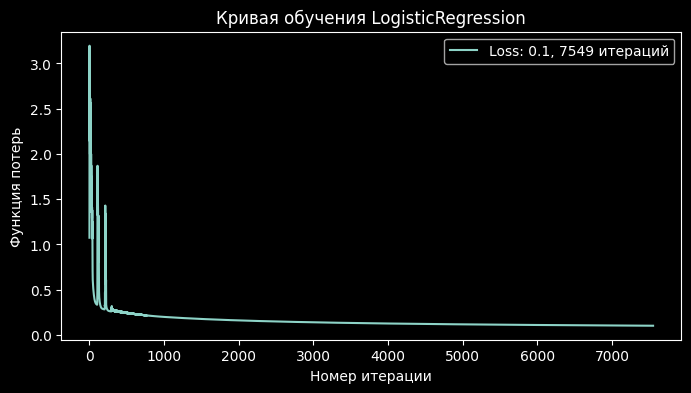

CPU times: total: 3.12 s
Wall time: 3.1 s


array([-43.12874851,  -4.21771412, -11.72404263,  35.19368713])

In [13]:
%%time
log_regressor = LogisticRegression(samples=X_scaled, targets=y,
                                   alpha=1e-0, diff_mse=1e-15, min_los=0.1,
                                   print_cost=True, fit_intercept=True,
                                   l1_penalty=0.00, l2_penalty=0.00)
log_l = log_regressor.fit()
log_w = log_regressor.get_weights()
plot_learning_curves(model=log_regressor)
log_w

3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса "1". На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model.

Model alpha: 1.0, diff_mse: 1e-15, iterations: 45, loss: 0.5884703596988022 ...


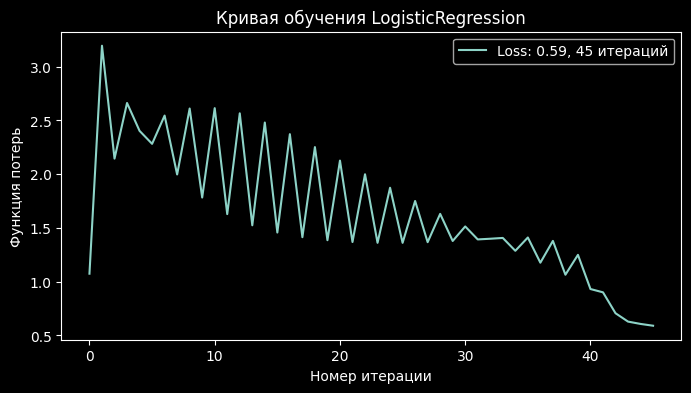

CPU times: total: 312 ms
Wall time: 324 ms


array([-3.02345767, -2.91251613,  2.90844242,  6.66140524])

In [14]:
%%time
log_regressor = LogisticRegression(samples=X_scaled, targets=y,
                                   alpha=1e-0, diff_mse=1e-15, min_los=0.6,
                                   print_cost=True, fit_intercept=True,
                                   l1_penalty=0.00, l2_penalty=0.00)
log_l = log_regressor.fit()
log_w = log_regressor.get_weights()
plot_learning_curves(model=log_regressor)
log_w

In [15]:
log_regressor.predict()

array([0.10681945, 0.28413624, 0.95790244, 0.1788964 , 0.98800129,
       0.9301039 , 0.99611663, 0.00243253, 0.08139428, 0.99028452])

4. Создайте функцию calc_pred, возвращающую предсказанные классы (0 или 1). На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model, а также порог вероятности.

Результат применения функции сигмоиды – это вероятность того, что аргумент функции (логит) $s(z_i)$ принадлежит одному из классов. Напишем новый метод в класс регрессии:

```python
def to_class(self, logit):
      return (logit >= self.threshold) * 1
```

In [16]:
yhat = log_regressor.calc_predict()

In [17]:
df = pd.DataFrame({'y': y.astype(int), 'yhat': yhat})
print(df.to_string(index=False))

 y  yhat
 0     0
 0     0
 1     1
 0     0
 1     1
 0     1
 1     1
 0     0
 1     0
 1     1


5. (*) Напишите функции для расчета accuracy, матрицы ошибок, precision и recall, а также F1-score.

In [18]:
tn = ((yhat == 0) * (y == 0)).sum()
fp = ((yhat == 1) * (y == 0)).sum()
fn = ((yhat == 0) * (y == 1)).sum()
tp = ((yhat == 1) * (y == 1)).sum()
np.array([[tn, fp], [fn, tp]])

array([[4, 1],
       [1, 4]])

In [19]:
log_regressor.classification_report()

True Positives:0.8000	True Negatives:0.8000
False Positives:0.2000	False Negatives:0.2000
Accuracy равно:0.8000
Recall равно:0.8000	Precision равно:0.8000
F-мера равно:0.8000


Сравним с результатами для LogisticRegression в Sklearn

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [21]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('LR', LogisticRegression(
        solver='liblinear',
        penalty='l2',
        fit_intercept=True,
        random_state=42
    ))])
pipe.fit(X, y)
y_pred = pipe.predict(X)

In [22]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

print(f'True Negative errors: {tn}')
print(f'False Positive errors: {fp}')
print(f'False Negative errors: {fn}')
print(f'True Positive errors: {tp}')

True Negative errors: 4
False Positive errors: 1
False Negative errors: 1
True Positive errors: 4


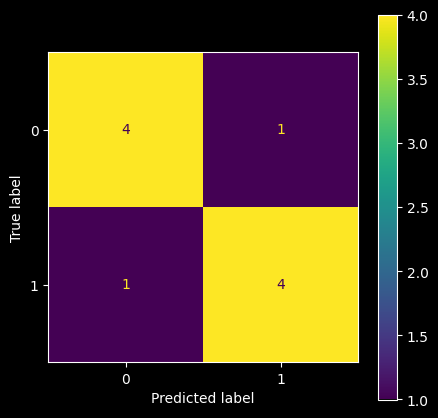

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_mx = confusion_matrix(y, y_pred, labels=pipe.classes_)

cmp = ConfusionMatrixDisplay(confusion_matrix=conf_mx)
fig, ax = plt.subplots(figsize=(5, 5))
cmp.plot(ax=ax)

plt.show()

In [24]:
ACC = np.diagonal(conf_mx).sum() / conf_mx.sum()  #или
# ACC = (yhat == y).mean()
PRECISION = conf_mx[1, 1] / conf_mx[:, 1].sum()
RECALL = conf_mx[1, 1] / conf_mx[1].sum()  

print(f"test ACC: {ACC}")
print(f"Precision: {PRECISION}")
print(f"Recall: {RECALL}")

test ACC: 0.8
Precision: 0.8
Recall: 0.8


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(f'Accuracy равно: {accuracy_score(y, y_pred):.3f}')
print(f'Precision равно: {precision_score(y, y_pred):.3f}')
print(f'Recall равно: {recall_score(y, y_pred):.3f}')
print(f'F-мера равно: {f1_score(y, y_pred):.3f}')

Accuracy равно: 0.800
Precision равно: 0.800
Recall равно: 0.800
F-мера равно: 0.800
